In [9]:
library('tidyverse')
library('scales')
library('viridis')

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




Data from:
https://github.com/rfordatascience/tidytuesday/blob/master/data/2023/2023-05-09/readme.md

In [2]:
childcare_costs = read.csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-05-09/childcare_costs.csv')

childcare_costs |> head()

,county_fips_code,study_year,unr_16,funr_16,munr_16,unr_20to64,funr_20to64,munr_20to64,flfpr_20to64,flfpr_20to64_under6,⋯,memp_p,femp_p,mcsa,mfccsa,mc_infant,mc_toddler,mc_preschool,mfcc_infant,mfcc_toddler,mfcc_preschool
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1001,2008,5.42,4.41,6.32,4.6,3.5,5.6,68.9,66.9,⋯,21.55,4.07,80.92,81.40,104.95,104.95,85.92,83.45,83.45,81.40
2,1001,2009,5.93,5.72,6.11,4.8,4.6,5.0,70.8,63.7,⋯,21.96,5.19,83.42,85.68,105.11,105.11,87.59,87.39,87.39,85.68
3,1001,2010,6.21,5.57,6.78,5.1,4.6,5.6,71.3,67.0,⋯,21.28,4.13,85.92,89.96,105.28,105.28,89.26,91.33,91.33,89.96
4,1001,2011,7.55,8.13,7.03,6.2,6.3,6.1,70.2,66.5,⋯,22.80,4.77,88.43,94.25,105.45,105.45,90.93,95.28,95.28,94.25
5,1001,2012,8.60,8.88,8.29,6.7,6.4,7.0,70.6,67.1,⋯,22.88,4.84,90.93,98.53,105.61,105.61,92.60,99.22,99.22,98.53
6,1001,2013,9.39,10.31,8.56,7.3,7.6,7.0,70.7,67.5,⋯,24.48,4.36,93.43,102.82,105.78,105.78,94.27,103.16,103.16,102.82


In [50]:
df_childcare=childcare_costs |>
    select(county_fips_code,study_year,mc_infant,mc_toddler,mc_preschool,mhi_2018)|>
    filter(str_detect(county_fips_code, '^50|^49'))|>
    drop_na()|>
    mutate(county_fips_code = case_when(county_fips_code >= 50000 &county_fips_code <= 50999 ~ "Vermont",
           county_fips_code >= 49000 &county_fips_code <= 49999 ~ "Utah"))|>
    group_by(county_fips_code,study_year)|>
    summarize(infant=mean(mc_infant),toddler=mean(mc_toddler),preschool=mean(mc_preschool),median_income=mean(mhi_2018))|>
    filter(county_fips_code!="NA")|>
    mutate(prop_infant = infant / infant[study_year == 2008],
           prop_income=median_income/median_income[study_year==2008])|>
    rename(State=county_fips_code)

df_childcare |> head()
    

`summarise()` has grouped output by 'county_fips_code'. You can override using
the `.groups` argument.


State,study_year,infant,toddler,preschool,median_income,prop_infant,prop_income
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Utah,2008,115.6972,94.57586,94.57586,57165.03,1.000000,1.000000
Utah,2009,121.2697,99.05724,99.05724,58362.46,1.048164,1.020947
Utah,2010,126.8424,103.53931,103.53931,59316.76,1.096330,1.037641
Utah,2011,132.4148,108.02138,108.02138,59115.45,1.144494,1.034119
Utah,2012,128.5986,106.41931,103.92345,58256.46,1.111510,1.019093
Utah,2013,124.7821,104.81897,99.82586,57878.50,1.078522,1.012481


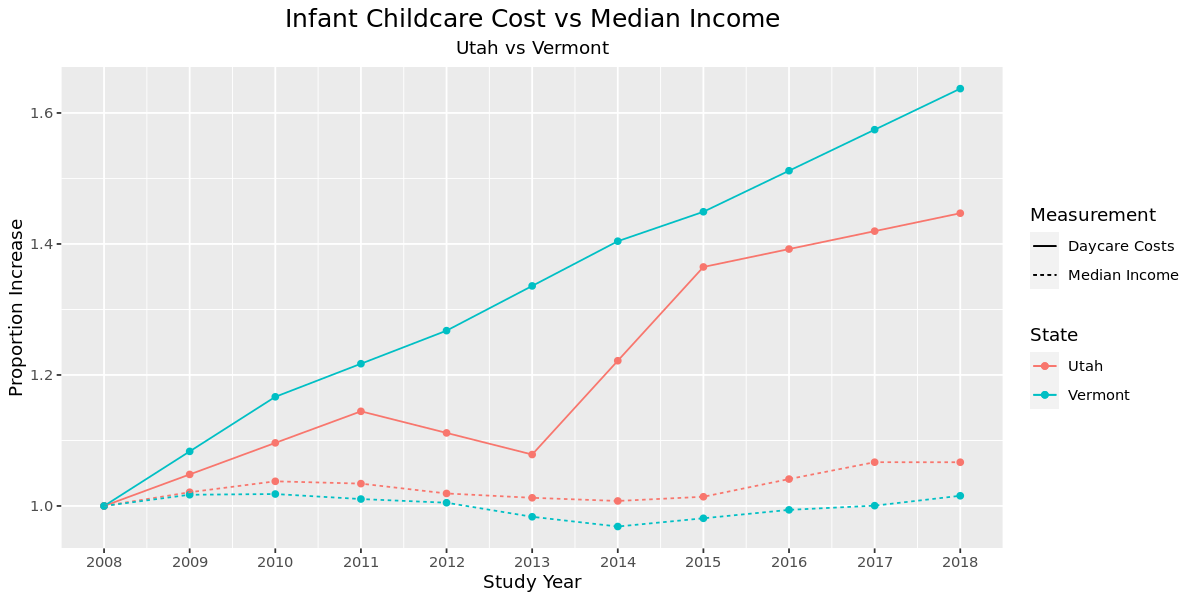

In [33]:
options(repr.plot.width=10,repr.plot.height=5)

childcare_line=ggplot(df_childcare,aes(x=study_year,colour=State))+
  geom_point(aes(y = prop_infant)) + 
  geom_line(aes(y = prop_infant,linetype="Daycare Costs")) + 
  geom_point(aes(y = prop_income)) + 
  geom_line(aes(y = prop_income,linetype="Median Income"))+
  labs(x="Study Year",y="Proportion Increase",title="Infant Childcare Cost vs Median Income",subtitle="Utah vs Vermont",linetype="Measurement")+
  scale_x_continuous(breaks=pretty_breaks(n=10))+
  scale_y_continuous(breaks=pretty_breaks(n=5))+
  theme(plot.title = element_text(hjust = 0.5,size = 15),plot.subtitle=element_text(hjust=0.5))

childcare_line

Obviously a lot of confounders here, but I chose the above states based on median age (and available data). Vermont has the 3rd highest median age and Utah has the lowest median age by state. Vermont had a larger proportional increase in childcare price despite median income staying relatively stagnant, though Utah had a similar trend. Crazy.

In [5]:
#center-based infant childcare cost by state 2018 (5 high, 5 low)
# 50 mississipi, alabama, kentucky, arkansas, south dakota (skip iowa and new mexico, data not available)
# 1 hawaii, california, new york, new jersey, washington state
df_childcare2=childcare_costs |>
    select(county_fips_code,study_year,mc_infant)|>
    drop_na()|>
    filter(study_year=="2018")|>
    group_by(county_fips_code)|>
    mutate(county_fips_code = case_when(county_fips_code >= 28000 &county_fips_code <= 28999 ~ "Mississippi",
           county_fips_code >= 1000 &county_fips_code <= 1999 ~ "Alabama",
           county_fips_code >= 21000 &county_fips_code <= 21999 ~ "Kentucky",
            county_fips_code >= 5000 &county_fips_code <= 5999 ~ "Arkansas",
            county_fips_code >= 46000 &county_fips_code <= 46999 ~ "South Dakota",
            county_fips_code >= 15000 &county_fips_code <= 15999 ~ "Hawaii",
            county_fips_code >= 6000 &county_fips_code <= 6999 ~ "California",
            county_fips_code >= 36000 &county_fips_code <= 36999 ~ "New York",
            county_fips_code >= 34000 &county_fips_code <= 34999 ~ "New Jersey",
            county_fips_code >= 53000 &county_fips_code <= 53999 ~ "Washington"))|>
    group_by(county_fips_code,study_year)|>
    summarize(infant=mean(mc_infant))|>
    rename(State=county_fips_code)|>
    arrange(infant)
    
df_childcare2

`summarise()` has grouped output by 'county_fips_code'. You can override using
the `.groups` argument.


State,study_year,infant
<chr>,<int>,<dbl>
Mississippi,2018,70.06476
South Dakota,2018,108.45485
Arkansas,2018,108.75000
Alabama,2018,117.65388
Kentucky,2018,122.88708
NA,2018,165.90982
Washington,2018,233.01897
New Jersey,2018,242.21286
New York,2018,249.28065


In [6]:
df_childcare3=df_childcare2|>
    filter(State!="NA")

df_childcare3
#turn into table

State,study_year,infant
<chr>,<int>,<dbl>
Mississippi,2018,70.06476
South Dakota,2018,108.45485
Arkansas,2018,108.75000
Alabama,2018,117.65388
Kentucky,2018,122.88708
Washington,2018,233.01897
New Jersey,2018,242.21286
New York,2018,249.28065
California,2018,277.34879


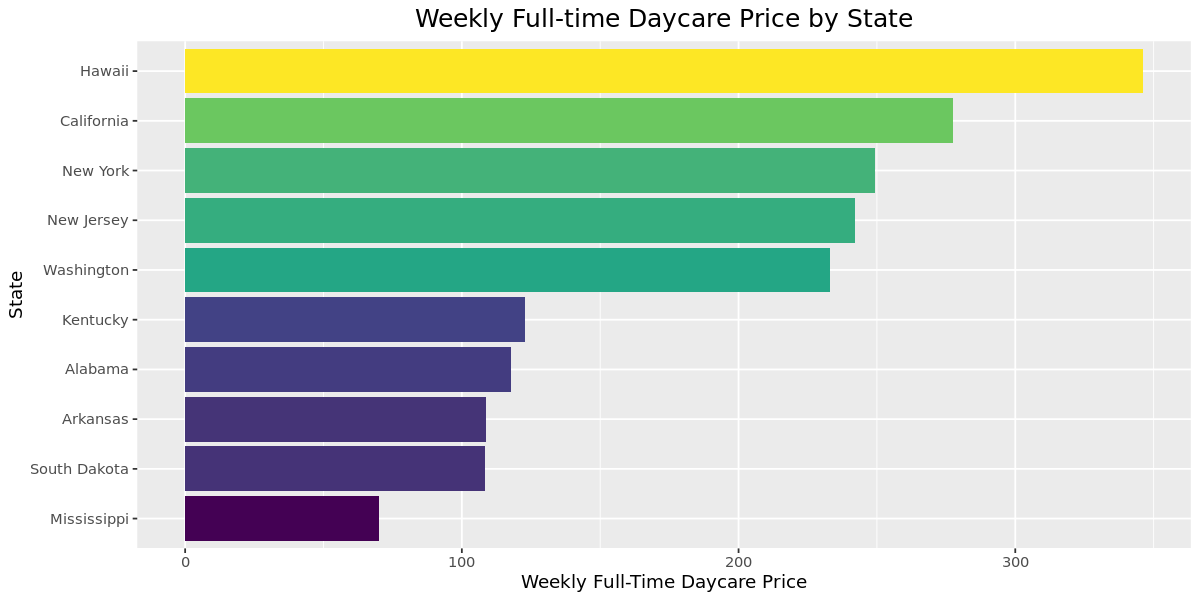

In [27]:
low_bar=ggplot(df_childcare3,aes(y=reorder(State,infant),x=infant,fill=infant))+
    geom_col()+
    labs(y="State",x="Weekly Full-Time Daycare Price")+
    scale_fill_continuous(type="viridis")+
    labs(title="Weekly Full-time Daycare Price by State")+
    theme(plot.title=element_text(hjust=0.5,size=15),legend.position="none")

low_bar

Above graph: 5 of the top median cost of living states and 5 of the low cost of living states (not specificially the 5 highest and lowest because of missing data)

In [45]:
df_childcare4=childcare_costs |>
    select(county_fips_code,study_year,mc_infant)|>
    filter()|>
    drop_na()|>
    mutate(county_fips_code = case_when(#county_fips_code >= 28000 &county_fips_code <= 28999 ~ "Mississippi",
           county_fips_code >= 1000 &county_fips_code <= 1999 ~ "Alabama",
           county_fips_code >= 21000 &county_fips_code <= 21999 ~ "Kentucky",
            # county_fips_code >= 5000 &county_fips_code <= 5999 ~ "Arkansas",
            county_fips_code >= 46000 &county_fips_code <= 46999 ~ "South Dakota",
            # county_fips_code >= 15000 &county_fips_code <= 15999 ~ "Hawaii",
            county_fips_code >= 6000 &county_fips_code <= 6999 ~ "California",
            # county_fips_code >= 36000 &county_fips_code <= 36999 ~ "New York",
            county_fips_code >= 34000 &county_fips_code <= 34999 ~ "New Jersey",
            county_fips_code >= 53000 &county_fips_code <= 53999 ~ "Washington"))|>
    group_by(county_fips_code,study_year)|>
    summarize(infant=mean(mc_infant))|>
    filter(county_fips_code!="NA")|>
    mutate(prop_infant = infant / infant[study_year == 2008])|>
    rename(State=county_fips_code)

df_childcare4 |> head()

`summarise()` has grouped output by 'county_fips_code'. You can override using
the `.groups` argument.


State,study_year,infant,prop_infant
<chr>,<int>,<dbl>,<dbl>
Alabama,2008,96.82910,1.000000
Alabama,2009,98.36478,1.015860
Alabama,2010,99.90358,1.031752
Alabama,2011,101.43970,1.047616
Alabama,2012,102.97582,1.063480
Alabama,2013,104.51119,1.079337


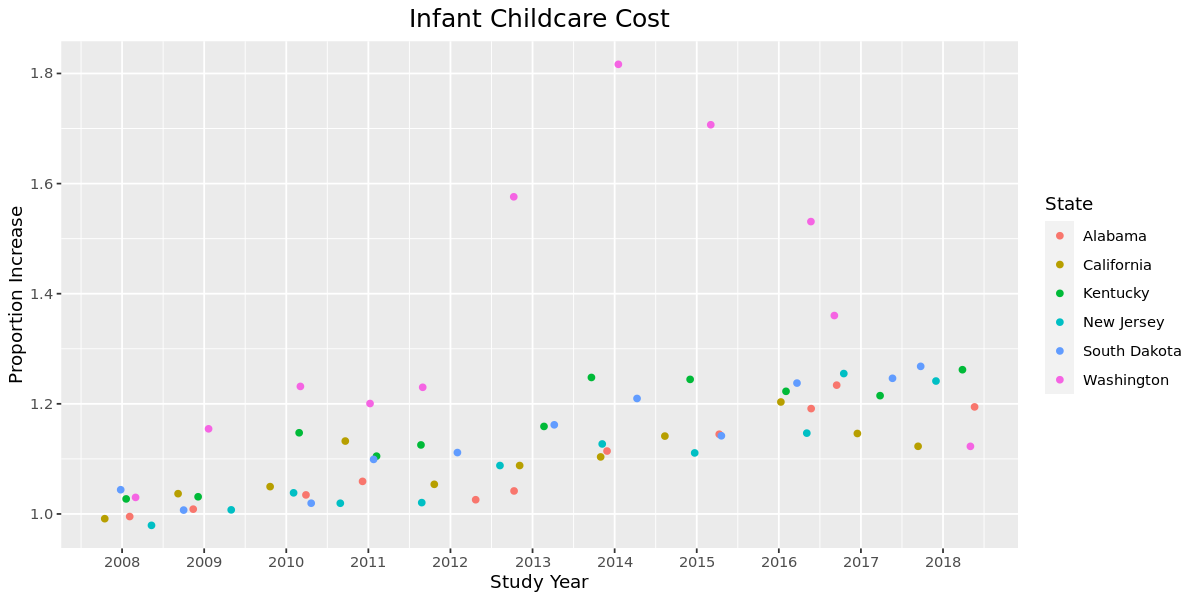

In [49]:
options(repr.plot.width=10,repr.plot.height=5)

childcare_line2=ggplot(df_childcare4,aes(x=study_year,colour=State))+
  geom_point(aes(y = prop_infant),position = position_jitter(h = 0.05)) + 
  labs(x="Study Year",y="Proportion Increase",title="Infant Childcare Cost",linetype="Measurement")+
  scale_x_continuous(breaks=pretty_breaks(n=10))+
  scale_y_continuous(breaks=pretty_breaks(n=5))+
  theme(plot.title = element_text(hjust = 0.5,size = 15),plot.subtitle=element_text(hjust=0.5))

childcare_line2

The scatterplot above is from the data for the bar chart, though there were (apparently) quite a few missing values that limited what states I could use. In general, we can see an upward trend of infant daycare prices in multiple states, high income and low income.